-0.05 + 0.4*dfc["shakespearianism_scaled"] - 0.18*dfc["invtrag"] + 0.1*dfc["tenaciousness_scaled"] - 0.16*dfc["elongation"]
Rolls of 0.001 or less are auto DPs

In [55]:
import load

df = load.data("groundout_formulas", season=18)

df = df[df['event_type']=='DP']


df["tragicness_scaled"] = load.player_attribute(df, 'batter', 'tragicness', vibes=False, mods="negative", items="negative", broken_items=True)

df["shakespearianism_scaled"] = load.player_attribute(df, 'pitcher', 'shakespearianism', vibes=True, mods=True, items=True, broken_items=True)

df["tenaciousness_scaled"] = load.player_attribute(df, 'fielder', 'tenaciousness', vibes=True, mods=True, items=True, broken_items=True)

df["elongation"] = load.stadium_attribute(df, 'elongation', center=True)
df["inconvenience"] = load.stadium_attribute(df, 'inconvenience', center=True)

In [56]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [82]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["SHELLED"]:
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    
dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

len(dfc)

3217

In [126]:
dfc["invtrag"] = 1 - dfc["tragicness_scaled"]
dfc["hypediff"] = (dfc["pitching_team_hype"] * (1 + 0.2*dfc["pitcher_vibes"])) - (dfc["batting_team_hype"] * (1 + 0.2*dfc["batter_vibes"]))
dfc["bhype"] = dfc["batting_team_hype"] 
dfc["phype"] = (dfc["pitching_team_hype"] * (1 + 0.2*dfc["pitcher_vibes"]))

In [127]:
X = dfc[
    [
        "roll",
        "passed",
        "invtrag",
        "shakespearianism_scaled",
        "tenaciousness_scaled",
        "elongation",
        #"batting_team_hype",
        #"pitching_team_hype"
        #"hypediff"
        #"bhype",
        #"phype"

    ]
].copy()
X = X[X["roll"] > 0.001]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = -0.05
pins = [ (0.4, "shakespearianism_scaled"), 
(-0.18, "invtrag"), 
(0.1, "tenaciousness_scaled"),
(-0.16, "elongation"),
#(0.14, "hypediff")
]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_   #- np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[2692    4]
 [   2  516]]
6 outliers
0.9981331673926571
-0.05


[(1.0, 'roll'),
 (0.13720080805486987, 'bhype'),
 (-0.13294842314165237, 'phype')]

In [90]:

dfc["threshold"] = -0.05 + 0.4*dfc["shakespearianism_scaled"] - 0.18*dfc["invtrag"] + 0.1*dfc["tenaciousness_scaled"] - 0.16*dfc["elongation"] + 0.13*dfc["hypediff"]

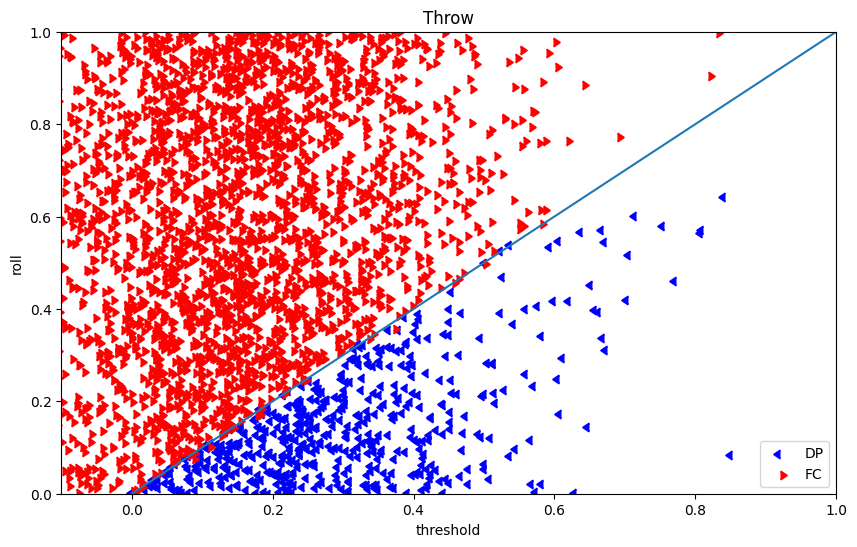

In [91]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="DP", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="FC", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Throw")
ax.set_xlim([-0.1, 1])
ax.set_ylim([0.0, 1.0])
ax.legend()

,offset,event_type,roll,threshold,season,batter_name,pitcher_name,weather,fielder_name,fielder_mods,day,game_id,play_count
4184,-0.005866,DP,0.169325,0.175191,18,Anathema Elemefayo,Yosh Carpenter,Weather.BLACK_HOLE,Jacob Winner,AFFINITY_FOR_CROWS;NON_IDOLIZED;SWIM_BLADDER,46,530b8c0c-f34b-41d8-9506-6840eaa7e5b5,30
3930,0.001073,DP,0.184185,0.183112,18,Collins Melon,Allan Kranch,Weather.COFFEE_3S,Mira Lemma,,43,fc01a7cc-86b5-4c68-8bc8-78c4f97e75fe,370
2703,-0.015113,DP,0.356341,0.371454,18,Don Mitchell,Jayden Wright,Weather.ECLIPSE,Nagomi Nava,UNDERPERFORMING;HOMEBODY;FIRE_EATER,32,55ccb30c-b067-4df3-bd4d-488ddeee3dd1,138
6153,-0.007682,DP,0.171466,0.179148,18,Lachlan Shelton,King Weatherman,Weather.BLACK_HOLE,Francisco Preston,SCATTERED,76,d1cff147-b7b6-4dba-8234-67fc392b442f,253
3359,-0.009369,DP,0.076064,0.085433,18,Lady Matsuyama,Tiana Takahashi,Weather.BIRDS,Eduardo Woodman,,38,b2d45639-ce9b-4a74-baee-5a033129f0ec,200
7251,-0.005749,DP,0.102155,0.107904,18,Sexton Wheerer,Riley Firewall,Weather.FLOODING,Walton Sports,FRIEND_OF_CROWS,89,da5ef8e7-ea3a-4d74-b0a8-e9df170822f7,65
6680,0.000986,DP,0.539267,0.538281,18,Trinity Smaht,Penelope Mathews,Weather.BLACK_HOLE,Malik Destiny,FIRE_EATER;ALTERNATE,82,16db12e3-abfb-430b-8209-66a34476e608,14
8107,-0.001422,DP,0.497030,0.498451,18,Zeruel Kramer,Mindy Kugel,Weather.SUN_2,Bees Taswell,AMBITIOUS;SCATTERED;SOUNDPROOF,97,77a94018-58e6-456d-8e57-7a608d9e4d81,232


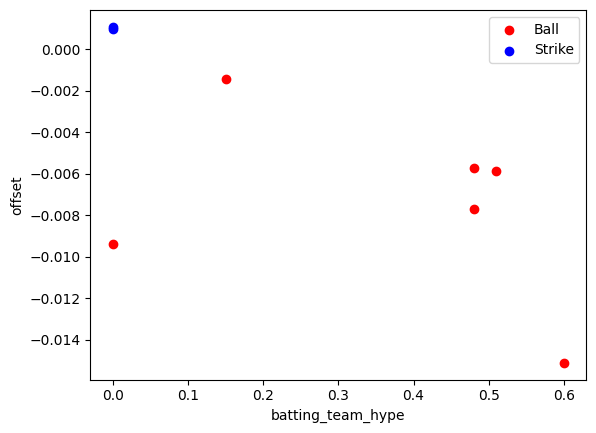

In [95]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
outliers = outliers[outliers["roll"] > 0.001]


fig, ax = plt.subplots(1)
x_val = "batting_team_hype"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Ball")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Strike")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type",
       "roll", "threshold", "season",
       "batter_name", "pitcher_name", "weather", "fielder_name", "fielder_mods",
       "day",  "game_id", "play_count"]].sort_values('batter_name')


In [43]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.5408178948511813
0.0014721651687263915
